In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1.054e-34
h = hbar*2*np.pi
qe = 1.602e-19
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

# Set qubit parameters

In [50]:
# q_in, q_switch, q_out1, q_out2

# EJs = [13.41, 12.52, 8.94, 12.52]
# EJs = [12.109, 11.195, 7.997, 11.195]
# EJs = [17.523, 16.450, 11.622, 16.450]

# ECs = [0.237, 0.133, 0.270, 0.215]

# gs = [0.0827, 0.0787, 0.0652] # g01, g12, g13
# gs = [1e-3*73.44448637160531, 1e-3*70.62005211780702, 1e-3*58.4998799537415]
# gs = [1e-3*88.68898701296644, 1e-3*85.3693409331001, 1e-3*70.91300299056793]
# gs = [0,0,0]
# gs = [1e-3*66.56542672271766, 1e-3*65.06457214018066, 1e-3*51.68752851908644]
# gs = [0.0613, 0.0600, 0.0475]

qubit_freqs = None
alphas = None


EJs = None
ECs = None
qubit_freqs = [4.838, 3.422, 4.099, 4.458]
alphas = [-0.182, -0.108, -0.220, -0.168]
gs = [0.043, 0.054, 0.04] # g01, g12, g13

# Analytical swap

In [51]:
cutoffs = [4, 5, 4, 4]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    qubit_freqs=qubit_freqs,
    alphas=alphas,
    cutoffs=cutoffs,
    isCavity=isCavity,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('alphas (GHz)', *alphas)
print('aprox sideband freqs (GHz)', 2*qubit_freqs[1] + alphas[1] - qubit_freqs)


# print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

qubit freqs (GHz) 4.838 3.422 4.099 4.458
alphas (GHz) -0.182 -0.108 -0.22 -0.168
aprox sideband freqs (GHz) [1.898 3.314 2.637 2.278]


In [52]:
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
print(1e3*qram.get_ZZ_matrix())

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
[[ 0.         -0.56224302 -0.01294185 -0.01609535]
 [-0.56224302  0.         -5.0692882  -0.87199601]
 [-0.01294185 -5.0692882   0.         -0.06006331]
 [-0.01609535 -0.87199601 -0.06006331  0.        ]]


In [38]:
# MAKE SURE DRESSED STATES ARE MAPPED CORRECTLY, AT LEAST FOR <= n EXCITATIONS
# qram.check_state_mapping(n=3)

## Create pulse sequence

In [85]:
seq = PulseSequence(start_time=0)
# wd1 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.17)
# wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01)
# wd3 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.08)
# wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', wd=wd1, amp=0.17)
# wd5 = qram.add_sequential_pi_pulse(seq, 'ggeg', 'geeg', amp=0.01) # should be same as wd2
# wd6 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.01)
# wd7 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01) # should be same as wd2 and should also drive geeg -> ggeg


print('wd0')
wd0 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.10, drive_qubit=1)
print('wd1')
wd1 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.01, drive_qubit=1)
print('wd2')
wd2 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.05, drive_qubit=1)
print('wd3')
wd3 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.10, drive_qubit=1, wd=wd0)
# wd4 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.05, drive_qubit=0, wd=wd1)
print('wd4')
wd4 = qram.add_sequential_pi_pulse(seq, 'ggeg', 'geeg', amp=0.01, drive_qubit=1)
print('wd5')
wd5 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.10, drive_qubit=1)
print('wd6')
wd6 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.0075, drive_qubit=1)
print('wd7')
# wd8 = qram.add_sequential_pi_pulse(seq, 'geeg', 'ggeg', amp=0.01, drive_qubit=1)

# wd7_1 = qram.get_wd('ggge', 'gege', amp=0.01, drive_qubit=1, verbose=True)
# wd7_2 = qram.get_wd('geeg', 'ggeg', amp=0.01, drive_qubit=1, verbose=True)
# wd7 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=0.01, 
#                                    drive_qubit=1, wd=np.average((wd7_1, wd7_2)))
print('Done.')

wd0
	new overlap 0.7375884854544483 wd 11.838195311238557 wd_res 0.25
	new overlap 0.7375884854544483 wd 11.838195311238557 wd_res 0.05
	new overlap 0.8827414251658333 wd 11.833195311238557 wd_res 0.005
	new overlap 0.9828115133943245 wd 11.835195311238557 wd_res 0.001
	new overlap 0.9959590320652394 wd 11.834795311238556 wd_res 0.0002
updated drive freq (GHz) from 1.8841073010709148 to 1.8835661742644023
wd1
	new overlap 0.9972518336420197 wd 21.452943613397778 wd_res 0.25
updated drive freq (GHz) from 3.414342019943963 to 3.414342019943963
wd2
	new overlap 0.8788338255863314 wd 16.4630932124061 wd_res 0.25
	new overlap 0.8788338255863314 wd 16.4630932124061 wd_res 0.05
	new overlap 0.9817631356533039 wd 16.4580932124061 wd_res 0.005
	new overlap 0.9953134002411802 wd 16.459093212406103 wd_res 0.001
updated drive freq (GHz) from 2.6201826633370615 to 2.6195460435646942
wd3
wd4
	new overlap 0.997139262624682 wd 21.424625013333767 wd_res 0.25
updated drive freq (GHz) from 3.409834974762

In [64]:
# CHECK FOR CLASHING LEVELS
tolerance = 100*MHz
problem_pulses = qram.check_level_resonances(seq, tolerance=tolerance)
good_freqs = seq.get_pulse_freqs(simplified=True)
print(good_freqs)
if len(problem_pulses.items()) == 0:
    print(f'No clashes found within {tolerance} GHz!')
for good_pulse, problem_pulse_dict in problem_pulses.items():
    print('Clashes to', tolerance,'GHz with', good_pulse[0], '<->', good_pulse[1], f'(freq = {good_freqs[good_pulse]})', 'tpi', qram.get_Tpi(good_pulse[0], good_pulse[1], amp=0.05))
    for problem_pulse, freq in problem_pulse_dict.items():
        diff_freq = np.abs(freq)-np.abs(good_freqs[good_pulse])
        if np.abs(diff_freq) > tolerance:
            diff_freq = 2*np.abs(freq)-np.abs(good_freqs[good_pulse])
        print('\t', 'GOOD PULSE' if problem_pulse in good_freqs.keys() else '', problem_pulse[0], '<->', problem_pulse[1], freq, f'(off by {diff_freq*1e3} MHz)', 'tpi', qram.get_Tpi(problem_pulse[0], problem_pulse[1], amp=0.05))

{('eggg', 'gfgg'): 1.8835661742644023, ('eegg', 'eggg'): 3.414342019943963, ('gfgg', 'ggeg'): 2.617716080029023, ('geeg', 'ggeg'): 3.409834974762333, ('gfgg', 'ggge'): 2.2632359215953217, ('gege', 'ggge'): 3.4140322669504473}
Clashes to 0.1 GHz with eegg <-> eggg (freq = 3.414342019943963) tpi 10.045823115207229
	 GOOD PULSE geeg <-> ggeg 3.409834974762333 (off by -4.50704518162981 MHz) tpi 10.114192880584824
	 GOOD PULSE gege <-> ggge 3.4140322669504473 (off by -0.3097529935156551 MHz) tpi 10.049171152855871
Clashes to 0.1 GHz with geeg <-> ggeg (freq = 3.409834974762333) tpi 10.114192880584824
	 GOOD PULSE eegg <-> eggg 3.414342019943963 (off by 4.50704518162981 MHz) tpi 10.045823115207229
	 GOOD PULSE gege <-> ggge 3.4140322669504473 (off by 4.1972921881141545 MHz) tpi 10.049171152855871
Clashes to 0.1 GHz with gege <-> ggge (freq = 3.4140322669504473) tpi 10.049171152855871
	 GOOD PULSE eegg <-> eggg 3.414342019943963 (off by 0.3097529935156551 MHz) tpi 10.045823115207229
	 GOOD PU

[1.8835661742644023, 3.414342019943963, 2.6195460435646942, 1.8835661742644023, 3.409834974762333, 2.262822118743283, 3.4140322669504473] (GHz)
[1660.1263768160325, 50.229115576036136, 676.3512962789631, 1660.1263768160325, 50.57096440292413, 986.1410467370423, 66.99447435237246] (ns)
total pulse length 5150.539650979404 ns


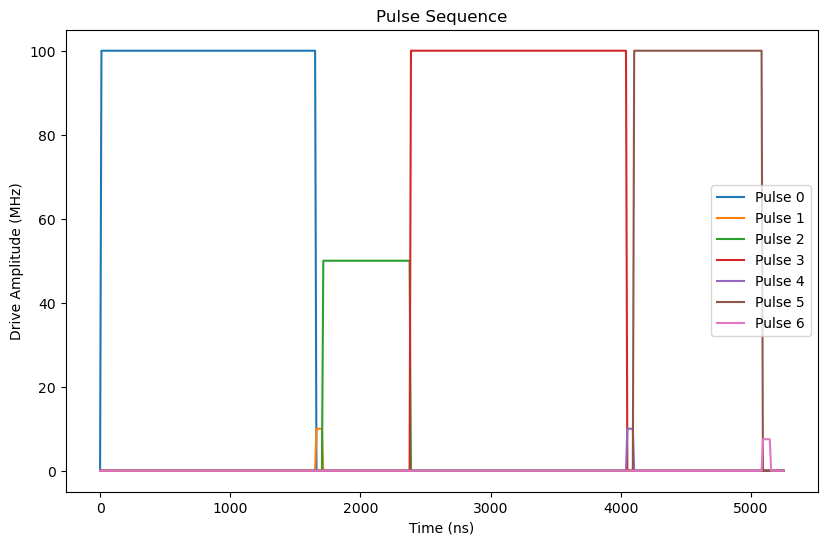

In [86]:
# times = np.linspace(0, 26000, 1000)
times = np.linspace(0, 5250, 500)
# times = np.linspace(0, 300, 700)
# times = np.linspace(0, 50, 100)

envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
print(seq.get_pulse_freqs(), '(GHz)')
print(seq.get_pulse_lengths(), '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')
for i in range(len(envelope_seq)):
    plt.plot(times, [pulse_amps[i]*envelope_seq[i](t)/MHz for t in times], label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
plt.title('Pulse Sequence')
plt.legend()
plt.show()

## Run simulation

In [9]:
T1 = 60e3 # ns
T2 = 30e3 # ?

# T1 = 10e3

# c_ops = [
#     np.sqrt(1/T1)*qram.a,
#     np.sqrt(1/T1)*qram.b,
#     np.sqrt(1/T1)*qram.c,
#     np.sqrt(1/T1)*qram.d,
# ]

c_ops = None

In [87]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'efgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

# psi0 = qram.state(psi0_name)
psi0 = np.sqrt(0.4) * qram.state('eggg') + np.sqrt(0.6) * qram.state('eegg') # QRAM start
# psi0 = np.sqrt(0.4) * qram.state('gggg') + np.sqrt(0.6) * qram.state('gegg') # QRAM start

# print(seq.get_pulse_str())

# result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=20000, use_str_solve=False)
result = qram.evolve_rot_frame(psi0, seq, times, c_ops=None, nsteps=20000)

10.0%. Run time:  33.55s. Est. time left: 00:00:05:01
20.0%. Run time:  70.96s. Est. time left: 00:00:04:43
30.0%. Run time: 108.29s. Est. time left: 00:00:04:12
40.0%. Run time: 133.37s. Est. time left: 00:00:03:20
50.0%. Run time: 164.54s. Est. time left: 00:00:02:44
60.0%. Run time: 202.82s. Est. time left: 00:00:02:15
70.0%. Run time: 241.01s. Est. time left: 00:00:01:43
80.0%. Run time: 275.20s. Est. time left: 00:00:01:08
90.0%. Run time: 307.03s. Est. time left: 00:00:00:34
Total run time: 329.47s


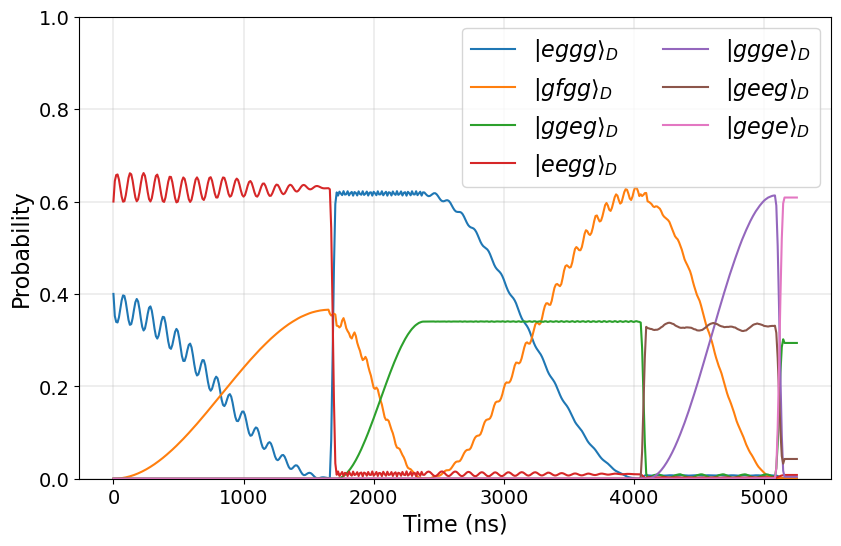

In [88]:
# states for 1 input
eggg = qram.state('eggg')
gfgg = qram.state('gfgg')
ggeg = qram.state('ggeg')
eegg = qram.state('eegg')
ggge = qram.state('ggge')
geeg = qram.state('geeg')
gege = qram.state('gege')
prob_eggg = [np.abs(eggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gfgg = [np.abs(gfgg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggeg = [np.abs(ggeg.overlap(result[t]))**2 for t in range(len(times))]
prob_eegg = [np.abs(eegg.overlap(result[t]))**2 for t in range(len(times))]
prob_ggge = [np.abs(ggge.overlap(result[t]))**2 for t in range(len(times))]
prob_geeg = [np.abs(geeg.overlap(result[t]))**2 for t in range(len(times))]
prob_gege = [np.abs(gege.overlap(result[t]))**2 for t in range(len(times))]

# states for 0 input
gggg = qram.state('gggg')
gegg = qram.state('gegg')
prob_gggg = [np.abs(gggg.overlap(result[t]))**2 for t in range(len(times))]
prob_gegg = [np.abs(gegg.overlap(result[t]))**2 for t in range(len(times))]


plt.plot(times, prob_eggg, label=r'$|eggg\rangle_D$')
plt.plot(times, prob_gfgg, label=r'$|gfgg\rangle_D$')
plt.plot(times, prob_ggeg, label=r'$|ggeg\rangle_D$')
plt.plot(times, prob_eegg, label=r'$|eegg\rangle_D$')
plt.plot(times, prob_ggge, label=r'$|ggge\rangle_D$')
plt.plot(times, prob_geeg, label=r'$|geeg\rangle_D$')
plt.plot(times, prob_gege, label=r'$|gege\rangle_D$')

# plt.plot(times, prob_gggg, label=r'$|gggg\rangle_D$')
# plt.plot(times, prob_gegg, label=r'$|gegg\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# for i1 in range(cutoffs[0]):
#     for i2 in range(cutoffs[1]):
#         for i3 in range(cutoffs[2]):
#             for i4 in range(cutoffs[3]):
#                 # print(qram.levels_nums_to_name([i1, i2, i3, i4]))
#                 plt.plot(times, 
#                          [np.abs(qram.state([i1, i2, i3, i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label='qram.level_nums_to_name[i1, i2, i3, i4]')

# plt.plot(times, [0.5]*len(times), 'k--', linewidth=0.5)
plt.legend(fontsize=16, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Probability', fontsize=16)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

Max fidelity [%]: 89.39673549113488
Final fidelity [%]: 89.39673549113488


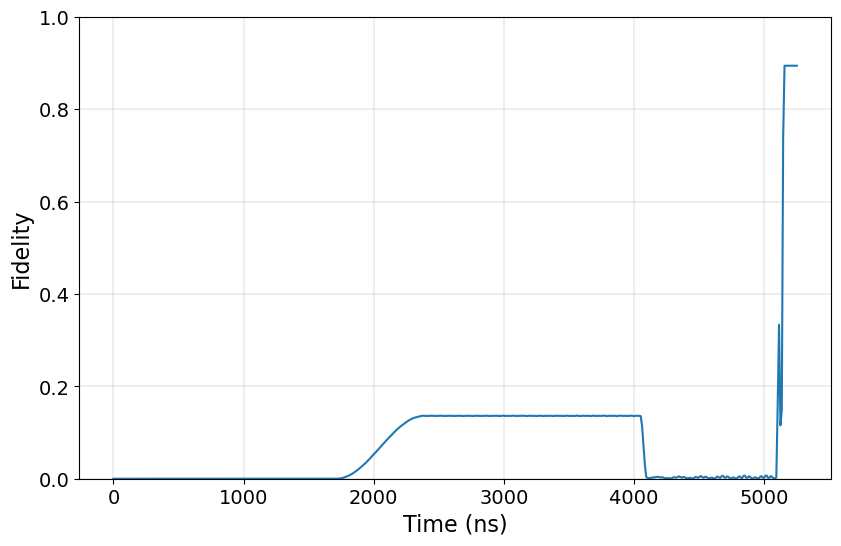

In [89]:
# ket_target = qram.state('ggeg')
ket_target = np.sqrt(0.4) * qram.state('ggeg') + np.sqrt(0.6) * qram.state('gege')
qram.fidelity(qram.state('ggeg'), result[-1])
qram.fidelity(qram.state('gege'), result[-1])

fidelities = [qram.fidelity(ket_target, result[t]) for t in range(len(times))]
print(f'Max fidelity [%]: {1e2*max(fidelities)}')
print(f'Final fidelity [%]: {1e2*fidelities[-1]}')

plt.plot(times, fidelities)

# plt.legend(fontsize=16, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Fidelity', fontsize=16)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

In [91]:
T = 30 # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
probs = dict()
print("Non-zero levels:")
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                prob = np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
                sum_psi += prob
                if prob > 0.01:
                    probs.update({qram.level_nums_to_name([i1, i2, i3, i4]):prob})
probs = sorted(probs.items(), key=lambda item:-item[1])
for level, prob in probs:
    print(level, prob)
print('Sum probabilities:', sum_psi)

Non-zero levels:
eegg 0.6585742816093219
eggg 0.33819118733219755
Sum probabilities: 1.0000000000000002


In [12]:
print('want', qram.get_base_wd('eggg', 'gfgg')/2/np.pi)
print('want', qram.get_base_wd('eegg', 'eggg')/2/np.pi)
# print('want', qram.get_wd('eggg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('eegg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('ggge', 'gege', 0.05, verbose=False)/2/np.pi)
# print('resonant to', qram.get_wd('ggeg', 'geeg', 0.05)/2/np.pi)
# print('2 photon transition to', qram.get_base_wd('eggg', 'efgg')/2/np.pi)

want 2.1692639480132065
want 3.6869102975757024
